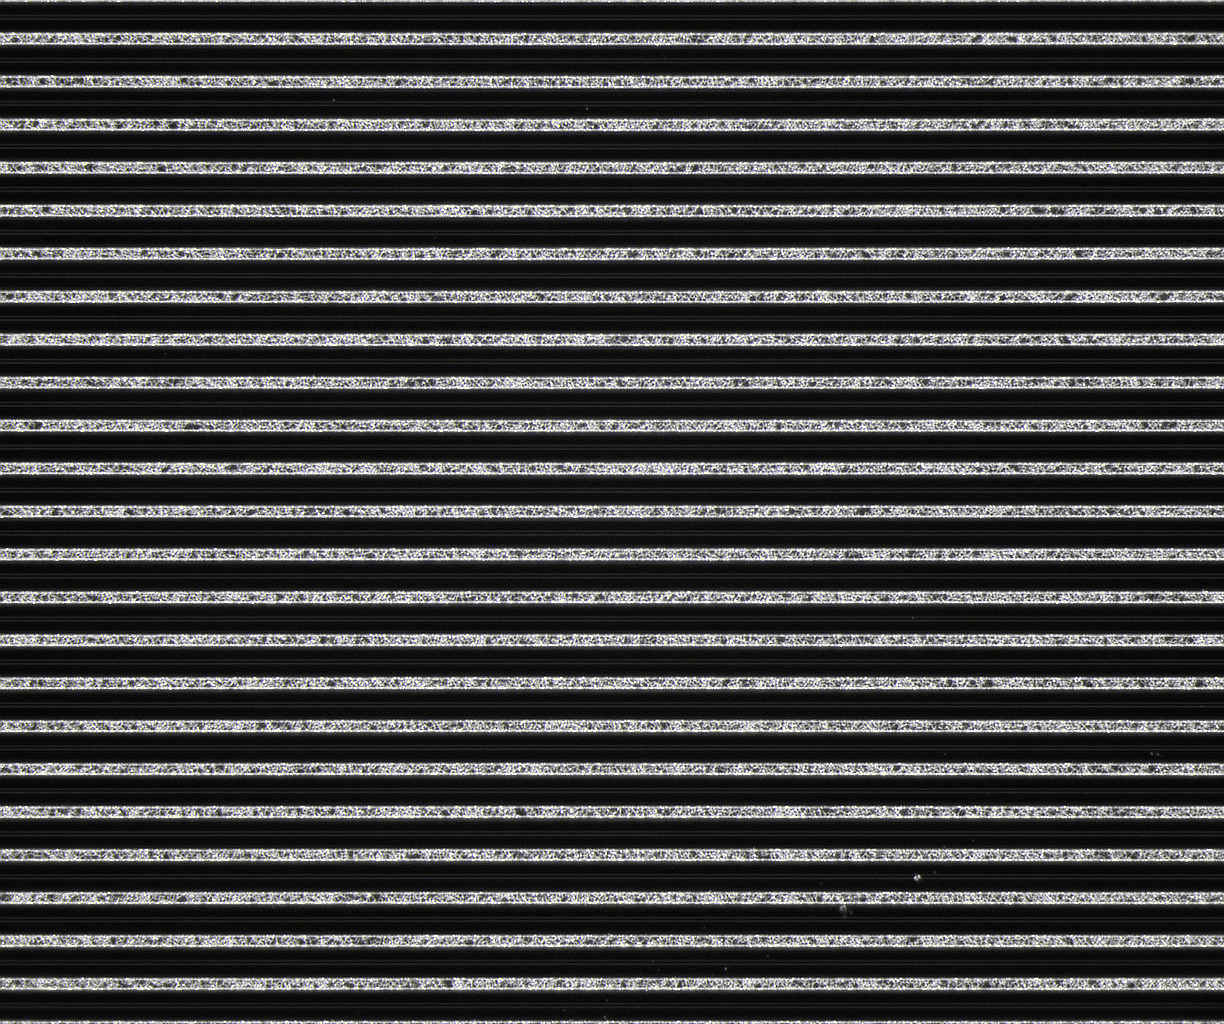

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

Image.open('VPX32409-W00065_08_09.bmp')

In [2]:
import os

filepath="sample_images_small/"

files = os.listdir(filepath)


for file in files:
    im = Image.open("sample_images_small/"+file)
    p = np.array(im)[:,:,0]

#     plt.imshow(p)
#     plt.show()

    # Split the image into 64 even pieces
    split = np.array([np.vsplit(x, 8) for x in np.hsplit(p, 8)])

    # Reshape to create different images exist across first dimension of array
    split = np.reshape(split, (1, -1, split.shape[2], split.shape[3]))
    split = np.squeeze(split,0)
    
    try:
        splitImages = np.concatenate((splitImages, split))
    except:
        splitImages = np.copy(split)

(6528, 128, 153)


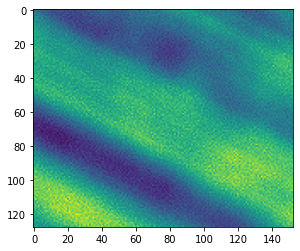

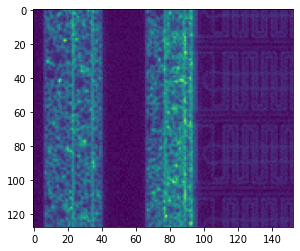

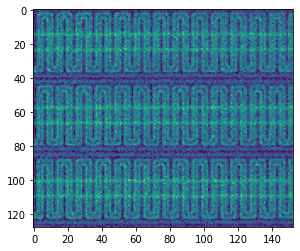

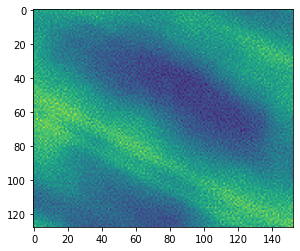

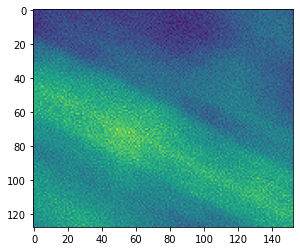

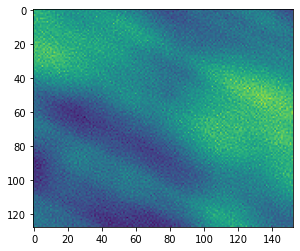

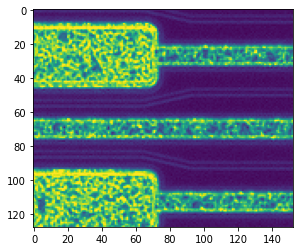

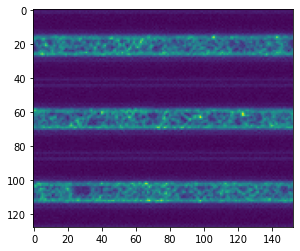

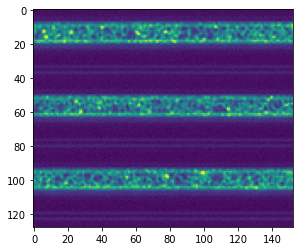

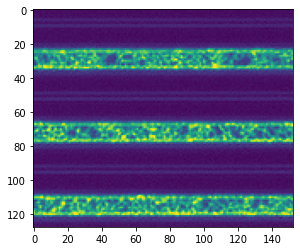

In [3]:
print(splitImages.shape)

for i in np.random.randint(0, splitImages.shape[0], 10):
    plt.imshow(splitImages[i])
    plt.show()

In [4]:
# TODO: I will come back to this and add different types of damage

from skimage.draw import line_aa
def addDamage(img):
    rr, cc, val = line_aa(np.random.randint(0,img.shape[0]), np.random.randint(0,img.shape[1]), np.random.randint(0,img.shape[0]), np.random.randint(0,img.shape[1]))
    img[rr, cc] = val * np.random.randint(0,255)
    return img

In [5]:
# Create a undamaged and a damaged version



undamagedImages = np.copy(splitImages)
damagedImages = np.array([addDamage(img) for img in np.copy(splitImages)])

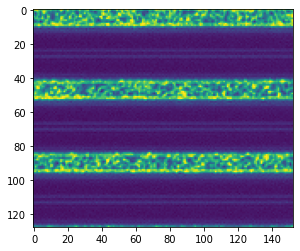

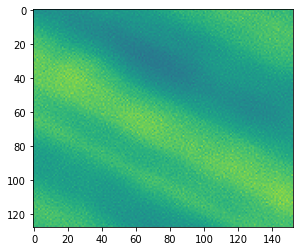

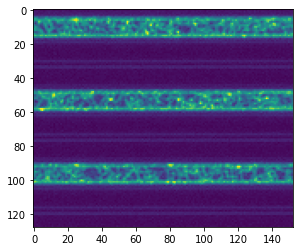

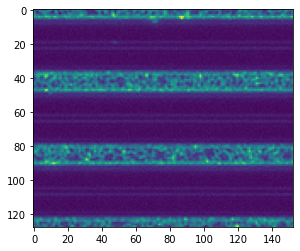

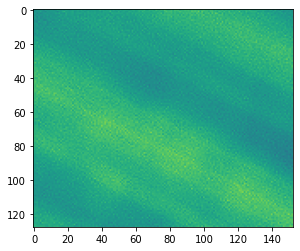

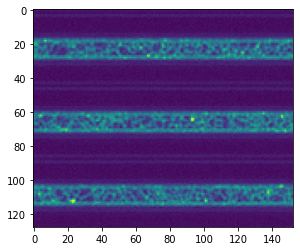

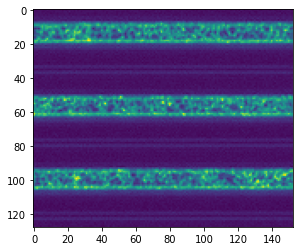

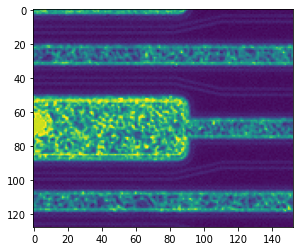

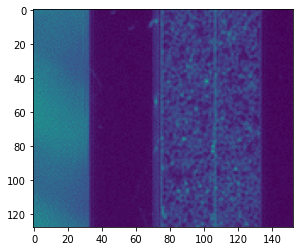

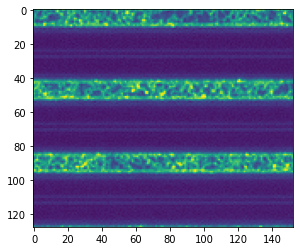

In [6]:


for i in np.random.randint(0, undamagedImages.shape[0], 10):
    plt.imshow(undamagedImages[i])
    plt.clim([0,255])
    plt.show()

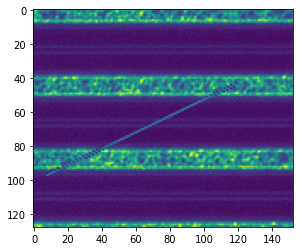

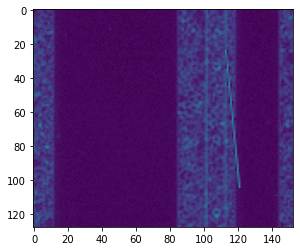

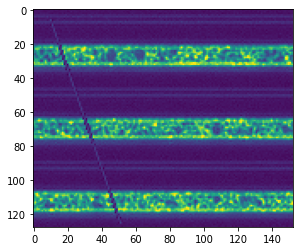

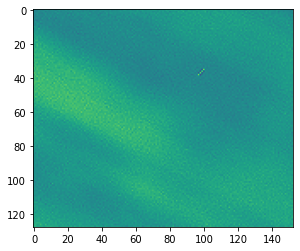

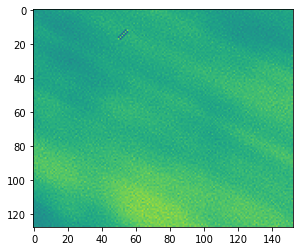

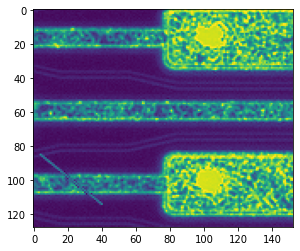

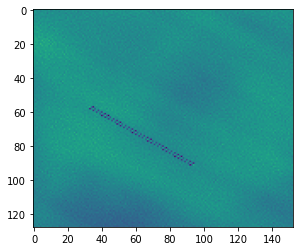

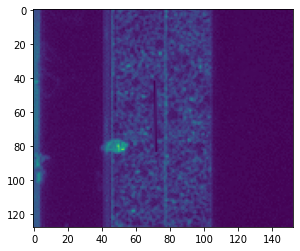

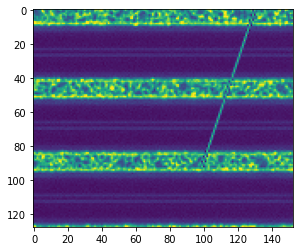

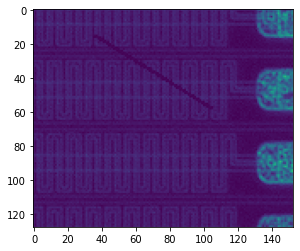

In [7]:
for i in np.random.randint(0, damagedImages.shape[0], 10):
    plt.imshow(damagedImages[i])
    plt.clim([0,255])
    plt.show()

In [8]:
fullData = np.concatenate((undamagedImages, damagedImages))
print(len(undamagedImages))

# https://numpy.org/doc/stable/reference/generated/numpy.full.html
fullDataLabels = np.concatenate((np.full((len(undamagedImages),2),[0,1]),
                                np.full((len(damagedImages),2),[1,0])))

print(fullData.shape)
print(fullDataLabels.shape)

6528
(13056, 128, 153)
(13056, 2)


In [9]:
# Shuffle the two lists around:
# https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
# TODO: See if we can do that thing in the first assignment

import random

c = list(zip(fullData, fullDataLabels))
random.shuffle(c)

fullData, fullDataLabels = zip(*c)
fullData=np.array(fullData)
fullDataLabels=np.array(fullDataLabels)

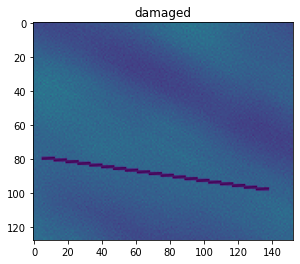

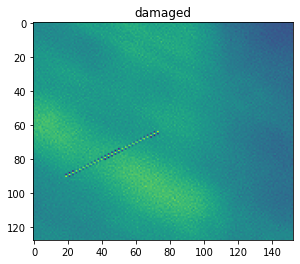

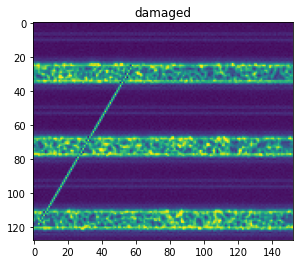

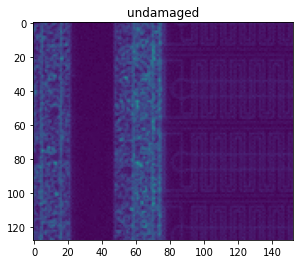

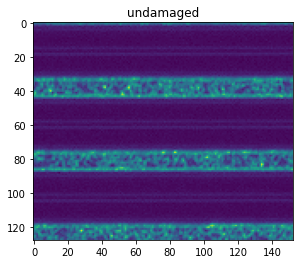

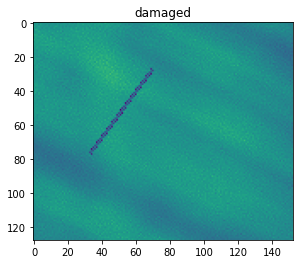

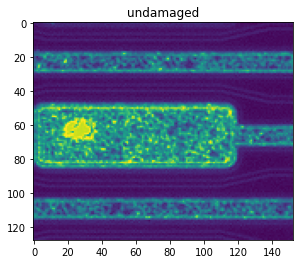

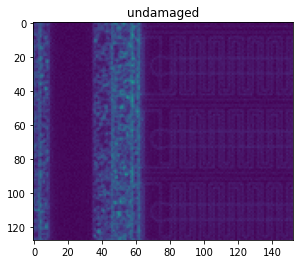

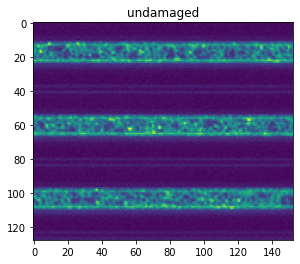

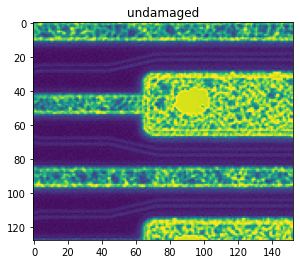

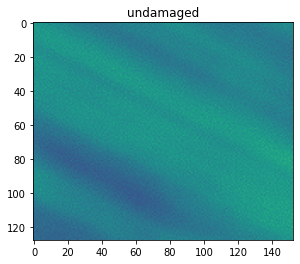

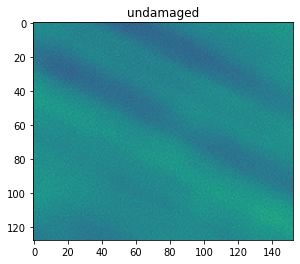

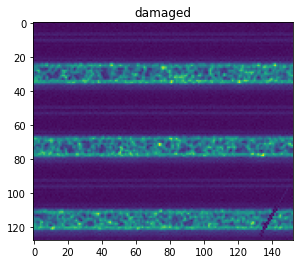

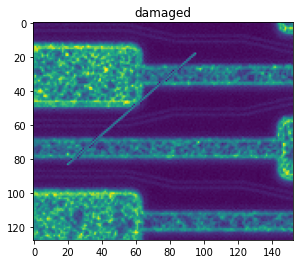

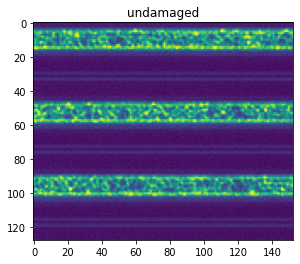

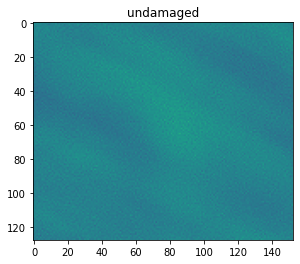

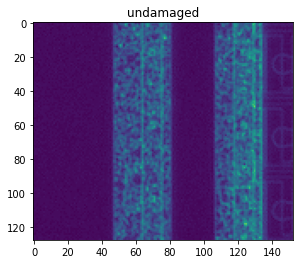

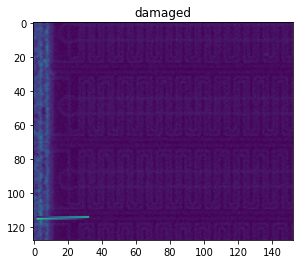

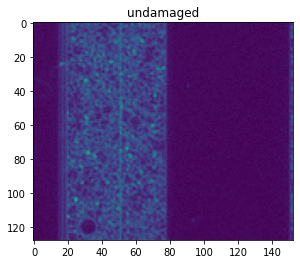

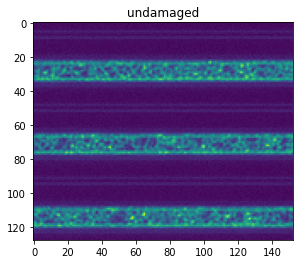

In [10]:
# These plots should show the ones with damage to be titled 1 and those without to be titled 0

for i in np.random.randint(0, damagedImages.shape[0], 20):
    plt.imshow(fullData[i])
    plt.clim([0,255])
    plt.title("damaged" if fullDataLabels[i][0] == 1 else "undamaged")
    plt.savefig("test_damage_sensors/"+str(i))
    plt.show()
    

In [11]:
# Split into training and test splits

splitIndex = int(len(fullDataLabels)/10)

testData = fullData[:splitIndex]
trainData = fullData[splitIndex:]

testDataLabels = fullDataLabels[:splitIndex]
trainDataLabels = fullDataLabels[splitIndex:]

print(len(testData))
print(len(trainData))

print(len(testDataLabels))
print(len(trainDataLabels))

print(trainData.shape[1:])
print(trainDataLabels.shape)


1305
11751
1305
11751
(128, 153)
(11751, 2)


In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
# Actually build the AI (ugh)



# # From: cnn_intro

# trainData = trainData.reshape((trainData.shape[0],128*153))
# testData = testData.reshape((testData.shape[0],128*153))


# # fcn_network = keras.models.Sequential()
# #
# # Hidden
# fcn_network.add(keras.layers.Dense(400,activation='tanh',input_shape=(128*153,)))

# # https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
# #
# # Output
# fcn_network.add(keras.layers.Dense(2,activation='sigmoid'))
# #
# # Compile
# fcn_network.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# # 
# # Fit/save/print summary
# history = fcn_network.fit(trainData,trainDataLabels,epochs=100,batch_size=128,validation_data=(testData,testDataLabels))
# fcn_network.save('fully_trained_model_fcn.h5')
# print(fcn_network.summary())

In [14]:
# Actually build the AI (ugh)

trainData = trainData.reshape((trainData.shape[0],128,153,1))
testData = testData.reshape((testData.shape[0],128,153,1))

# From: cnn_intro

# https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

cnn_network = keras.models.Sequential()
#
# First convolutional layer
cnn_network.add(keras.layers.Conv2D(30,(5,5),activation='relu',input_shape=(128,153,1)))
# Pool
cnn_network.add(keras.layers.MaxPooling2D((2,2)))
#
# Second convolutional layer
cnn_network.add(keras.layers.Conv2D(25,(5,5),activation='relu'))
# Pool
cnn_network.add(keras.layers.MaxPooling2D((2,2)))
#
# Connect to a dense output layer - just like an FCN
cnn_network.add(keras.layers.Flatten())
cnn_network.add(keras.layers.Dense(64,activation='relu'))
cnn_network.add(keras.layers.Dense(2,activation='sigmoid'))
#
# Compile
cnn_network.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#
# Fit/save/print summary
history = cnn_network.fit(trainData,trainDataLabels,epochs=10,batch_size=256,validation_data=(testData,testDataLabels))
cnn_network.save('fully_trained_model_cnn.h5')
print(cnn_network.summary())

Epoch 1/10
46/46 [==============================] - 77s 2s/step - loss: 9.5727 - accuracy: 0.5073 - val_loss: 0.6834 - val_accuracy: 0.5962
Epoch 2/10
46/46 [==============================] - 76s 2s/step - loss: 0.6276 - accuracy: 0.6331 - val_loss: 0.5660 - val_accuracy: 0.7433
Epoch 3/10
46/46 [==============================] - 76s 2s/step - loss: 0.5397 - accuracy: 0.7361 - val_loss: 0.5183 - val_accuracy: 0.7693
Epoch 4/10
46/46 [==============================] - 76s 2s/step - loss: 0.4989 - accuracy: 0.7681 - val_loss: 0.4795 - val_accuracy: 0.8253
Epoch 5/10
46/46 [==============================] - 76s 2s/step - loss: 0.4762 - accuracy: 0.8021 - val_loss: 0.6830 - val_accuracy: 0.5395
Epoch 6/10
46/46 [==============================] - 76s 2s/step - loss: 0.6945 - accuracy: 0.5054 - val_loss: 0.6919 - val_accuracy: 0.5211
Epoch 7/10
46/46 [==============================] - 76s 2s/step - loss: 0.6765 - accuracy: 0.5394 - val_loss: 0.6471 - val_accuracy: 0.6054
Epoch 8/10
46/46 [==

In [15]:
trainData.shape

(11751, 128, 153, 1)